Time series analysis. In this part, we focus on time series data of Stereo-seq Mouse embryo

In [1]:
import scanpy as sc
import numpy as np
import sctm
import squidpy as sq
import pandas as pd
import seaborn as sns
import anndata as ad

%load_ext autoreload
%autoreload 2

/home/chengwei/miniconda3/envs/torch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
adata = sc.read_h5ad("../../../../STAMP/Stereo_embryo/adata_clean.h5ad")

/home/chengwei/miniconda3/envs/torch/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/home/chengwei/miniconda3/envs/torch/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/chengwei/miniconda3/envs/torch/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


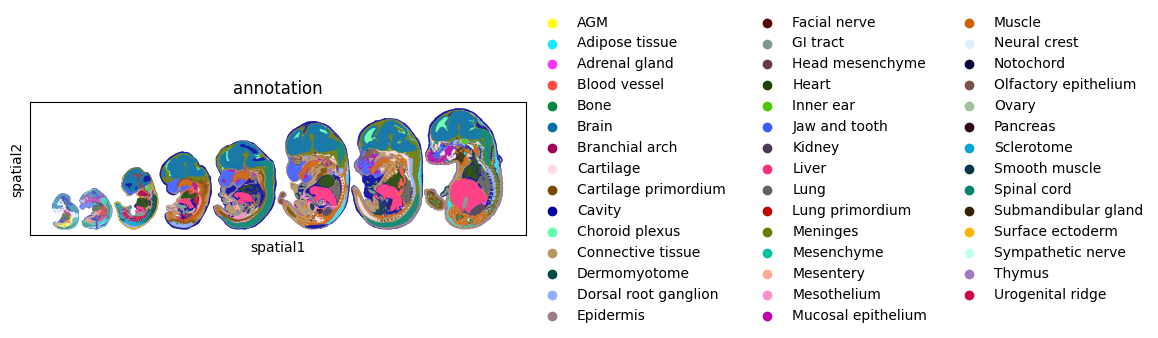

In [7]:
sctm.pl.spatial(adata, color = "annotation", size = 0.3)

We work with a downsampled data here

In [22]:
target_cells = 5000
cluster_key = "timepoint"
adatas = [adata[adata.obs[cluster_key] == clust] for clust in adata.obs[cluster_key].cat.categories]

for dat in adatas:
    if dat.n_obs > 10000:
        num = round(0.1 * dat.n_obs) + target_cells
        sc.pp.subsample(dat, n_obs = num)
        
adata_downsampled = adatas[0].concatenate(*adatas[1:])

/home/chengwei/miniconda3/envs/torch/lib/python3.10/site-packages/anndata/_core/anndata.py:1823: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(


In [23]:
adata_downsampled.obs.timepoint.value_counts()

timepoint
E16.5    17172
E15.5    16322
E14.5    15249
E13.5    12713
E12.5    10132
E10.5     8494
E11.5     8005
E9.5      5892
Name: count, dtype: int64

/home/chengwei/miniconda3/envs/torch/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/home/chengwei/miniconda3/envs/torch/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/chengwei/miniconda3/envs/torch/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


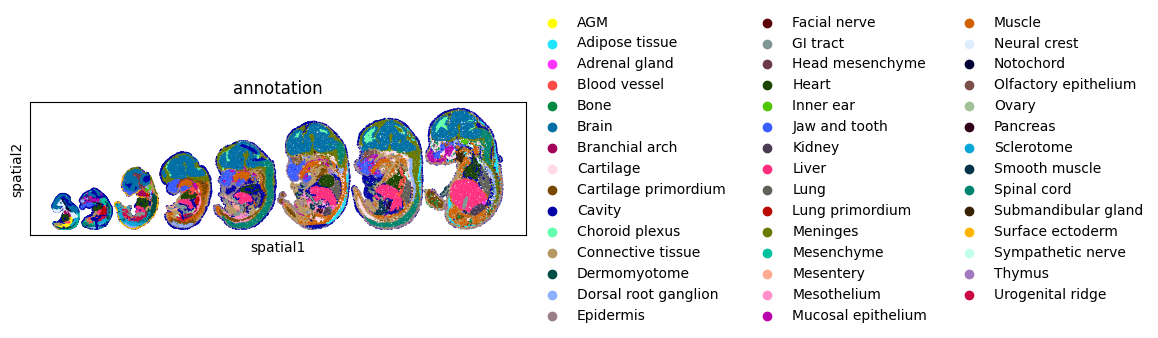

In [24]:
sctm.pl.spatial(adata_downsampled, color = "annotation", size = 3)

In [30]:
# We uses 10 neighbors here. Roughly (1/1000) * size
sq.gr.spatial_neighbors(adata_downsampled, n_neighs = 10)

In [32]:
sctm.seed.seed_everything(0)

model = sctm.stamp.STAMP(
    adata_downsampled,
    n_topics = 30,
    layer="count",
    time_covariate_keys="time",
    gene_likelihood="nb")

# We uses a weighted sampler so that each batch is sampled equally. However since we downsampled, it doesnt actually matters much 
model.train(learning_rate = 0.01, device = "cuda:0", sampler = "W", max_epochs = 10)

Computing background frequencies
Computing background frequencies
Computing background frequencies
Computing background frequencies
Computing background frequencies
Computing background frequencies
Computing background frequencies
Computing background frequencies


  0%|          | 0/10 [00:00<?, ?it/s]/home/chengwei/miniconda3/envs/torch/lib/python3.10/site-packages/pyro/primitives.py:443: UserWarning: encoder.norm_topic.0.weight was not registered in the param store because requires_grad=False. You can silence this warning by calling my_module.train(False)
  warnings.warn(
/home/chengwei/miniconda3/envs/torch/lib/python3.10/site-packages/pyro/primitives.py:443: UserWarning: encoder.norm_topic.1.weight was not registered in the param store because requires_grad=False. You can silence this warning by calling my_module.train(False)
  warnings.warn(
/home/chengwei/miniconda3/envs/torch/lib/python3.10/site-packages/pyro/primitives.py:443: UserWarning: encoder.norm_topic.2.weight was not registered in the param store because requires_grad=False. You can silence this warning by calling my_module.train(False)
  warnings.warn(
/home/chengwei/miniconda3/envs/torch/lib/python3.10/site-packages/pyro/primitives.py:443: UserWarning: encoder.norm_topic.3.weig

In [34]:
topic_prop = model.get_cell_by_topic()
beta = model.get_feature_by_topic()
for i in topic_prop.columns:
    adata_downsampled.obs[i] =  topic_prop[i]

/home/chengwei/miniconda3/envs/torch/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


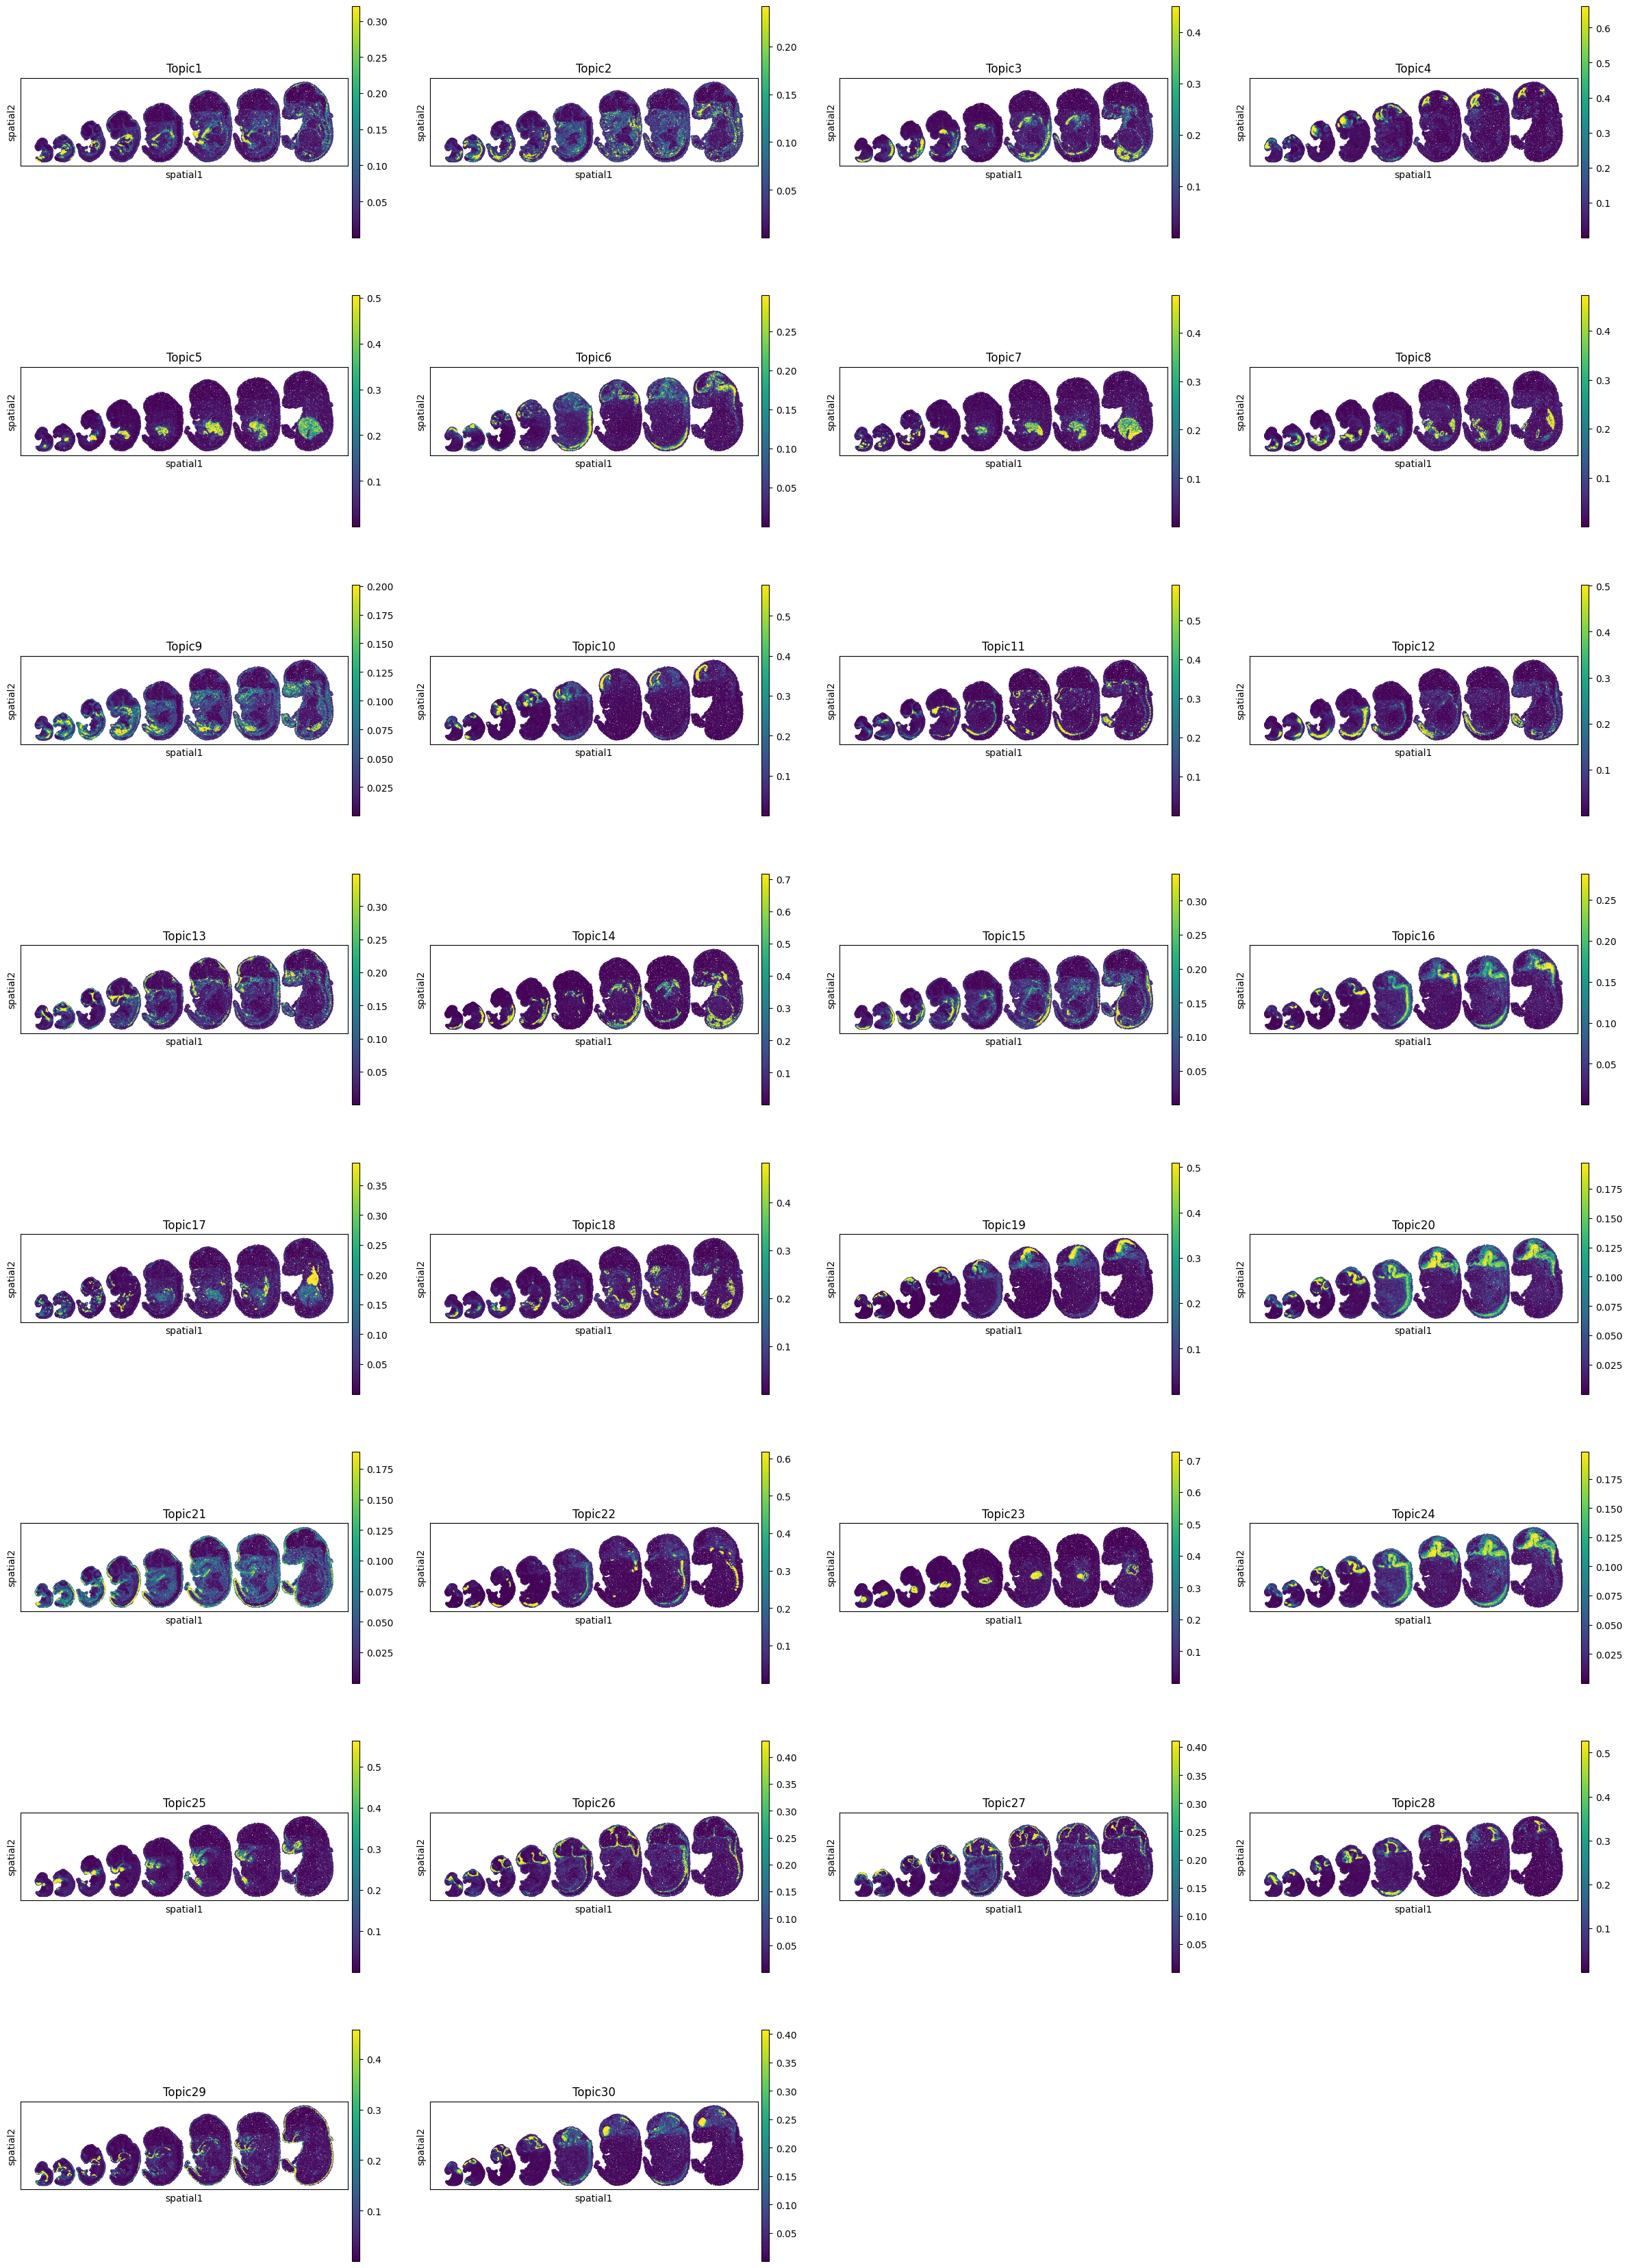

In [36]:
sctm.pl.spatial(adata_downsampled, color = topic_prop.columns, size = 3, vmax = 'p99')

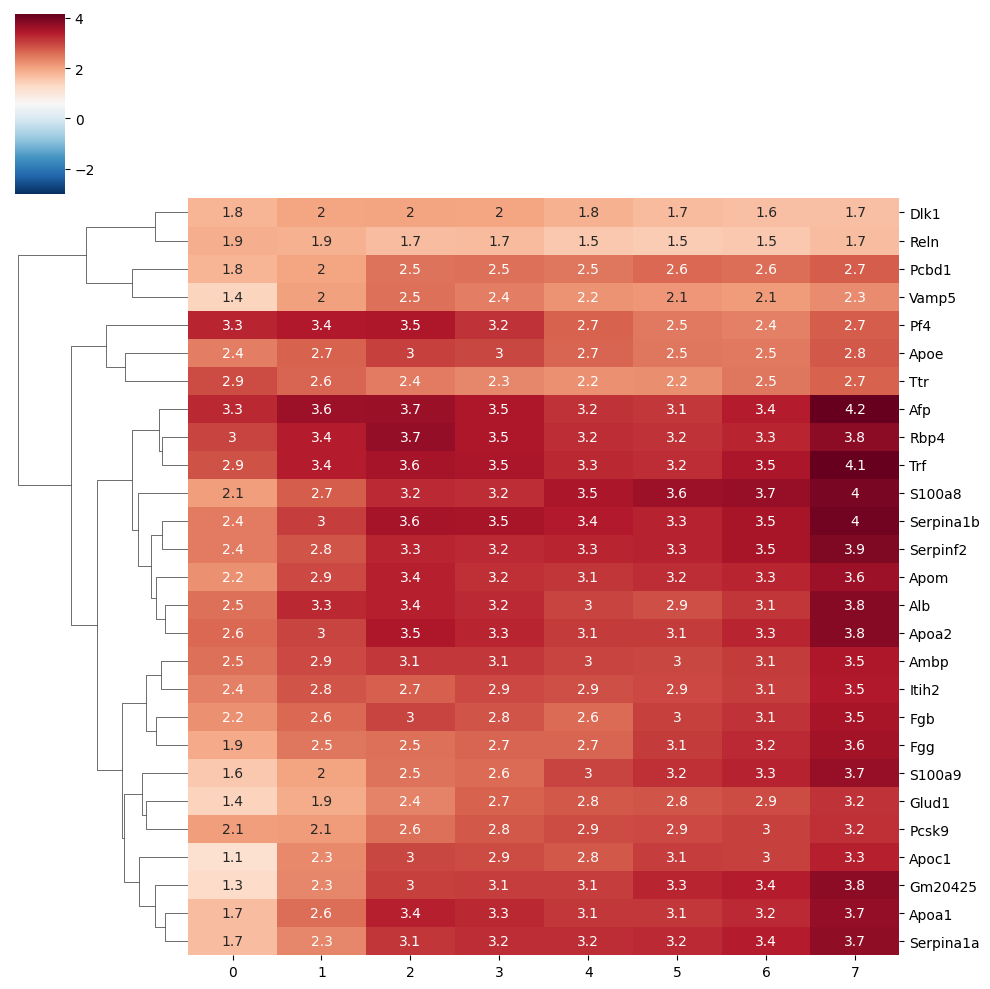

In [40]:
# Topic 5 is the liver
topic = "Topic5"
genes = []
for i in range(8):
    genes += (beta.xs(topic, level = 1).transpose().nlargest(20, i).index.tolist())
genes = np.unique(genes)

beta.xs(topic, level = 1).rank(ascending = False, axis = 1).transpose().loc[genes]

sns.clustermap(beta.xs(topic, level = 1).transpose().loc[genes], col_cluster=False, cmap = "RdBu_r",  vmin = -3, xticklabels=True, yticklabels=True, annot = True)